In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

import time


In [24]:
batch_size = 16
epochs = 50
image_size = (512, 512)

In [25]:
# trdata = ImageDataGenerator()
# traindata = trdata.flow_from_directory(directory="training/Train", target_size=target_size, batch_size=batch_size)
# tsdata = ImageDataGenerator()
# testdata = tsdata.flow_from_directory(directory="training/Test", target_size=target_size, batch_size=batch_size)
train_ds = keras.preprocessing.image_dataset_from_directory(
    'training/BRACOL_dataset',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    'training/BRACOL_dataset',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1216 files belonging to 2 classes.
Using 973 files for training.
Found 1216 files belonging to 2 classes.
Using 243 files for validation.


In [26]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f'Class names: {class_names}')
print(f'Number of classes: {num_classes}')

Class names: ['diseased', 'healthy']
Number of classes: 2


In [27]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(image_size[0], image_size[1], 3)),
        keras.layers.experimental.preprocessing.RandomFlip('vertical', input_shape=(image_size[0], image_size[1], 3)),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
        keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
model = Sequential([
    data_augmentation,
    normalization_layer,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)     

In [31]:
opt = Adam(lr=0.001)
history = model.compile(
    optimizer=opt,
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

c:\users\dudes\desktop\programação\projetos pycharm\dl-improvement\venv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [32]:
checkpoint = ModelCheckpoint('MyModel_1.h5', monitor='accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [33]:
start = time.time()
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint, early]
)
# hist = model.fit_generator(generator=train_ds, validation_data=val_ds,
#                            validation_steps=10, epochs=epochs, callbacks=[checkpoint, early])
print(f'\nElapsed time: {time.time() - start:.2f} seconds')

Epoch 1/50
 1/61 [..............................] - ETA: 7:44 - loss: 0.6900 - accuracy: 0.5000
Epoch 00001: accuracy improved from -inf to 0.50000, saving model to MyModel_1.h5
 2/61 [..............................] - ETA: 1:48 - loss: 1.8638 - accuracy: 0.6875
Epoch 00001: accuracy improved from 0.50000 to 0.68750, saving model to MyModel_1.h5
 3/61 [>.............................] - ETA: 1:42 - loss: 1.2425 - accuracy: 0.7917
Epoch 00001: accuracy improved from 0.68750 to 0.79167, saving model to MyModel_1.h5
 4/61 [>.............................] - ETA: 1:39 - loss: 0.9320 - accuracy: 0.8438
Epoch 00001: accuracy improved from 0.79167 to 0.84375, saving model to MyModel_1.h5
 5/61 [=>............................] - ETA: 1:37 - loss: 0.7962 - accuracy: 0.8625
Epoch 00001: accuracy improved from 0.84375 to 0.86250, saving model to MyModel_1.h5
 6/61 [=>............................] - ETA: 1:35 - loss: 0.7282 - accuracy: 0.8646
Epoch 00001: accuracy improved from 0.86250 to 0.86458, s

Text(0.5, 1.0, 'Training and Validation Loss')

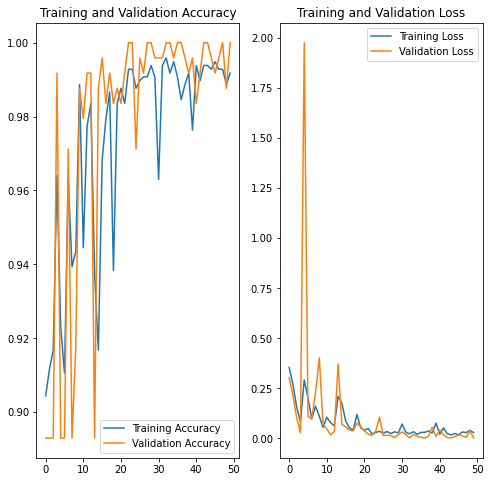

In [35]:
# plt.plot(hist.history["accuracy"])
# plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title("Model Accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
# plt.show()
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [36]:
model.save(f'Models/Batch Size {batch_size} - Epochs {epochs}.h5')
